In [1]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
from ctse.systems.ct_system import ct_system
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paper.topic.spectrum import signal_fft, psd

system = ct_system()
rawdata = system.rawdata
data = system.data

2022-11-23 14:33:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvFxPricesData in csv_data_paths, will use defaults (may break in production, should be fine in sim)
2022-11-23 14:33:50 {'type': 'csvFuturesSimData'} [Warning] No key for csvRollParametersData in csv_data_paths, will use defaults (may break in production, should be fine in sim)


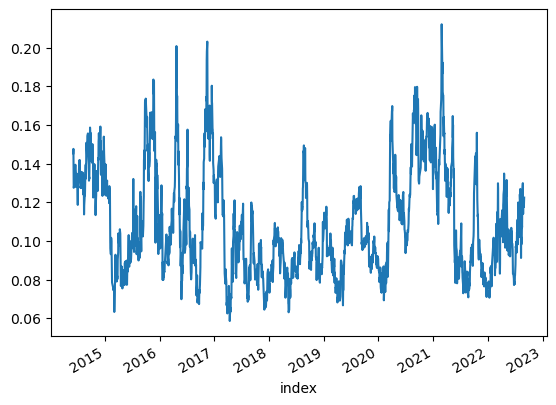

F=0.0009940357852882703, T=1006.0000000000001, Amplitude=0.011909603331285124
F=0.0019880715705765406, T=503.00000000000006, Amplitude=0.014640892747540065


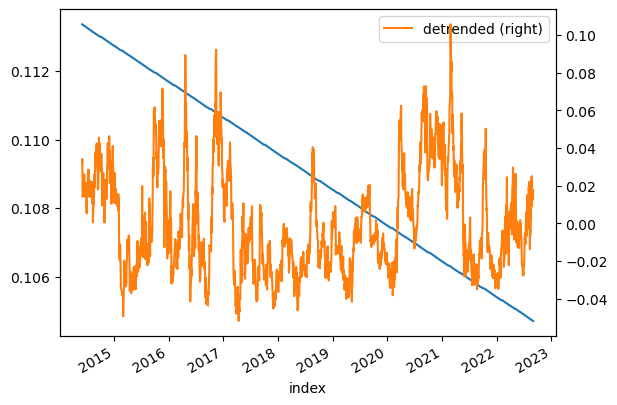

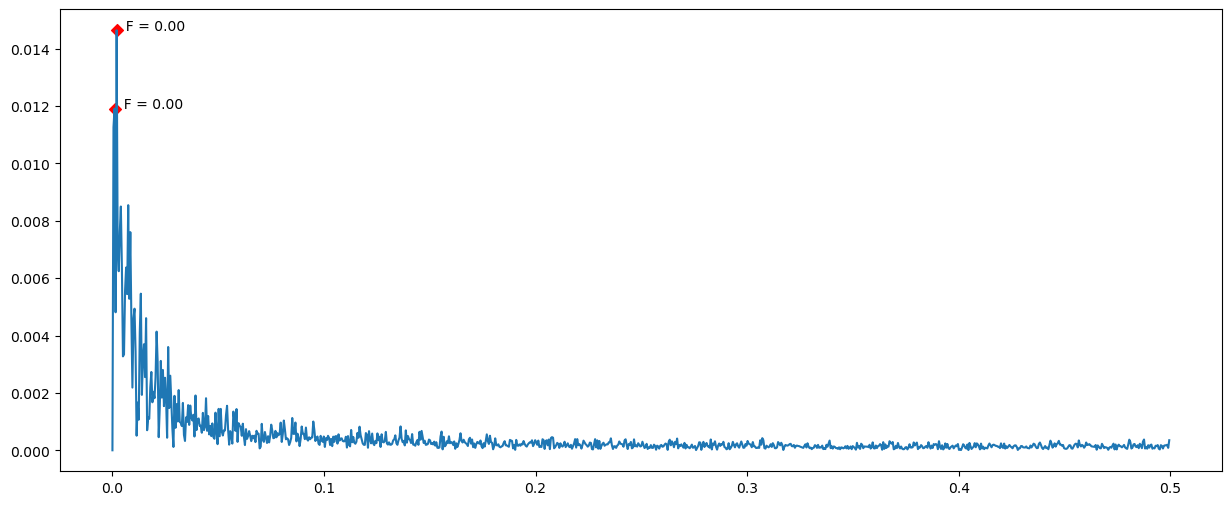

In [2]:
def snr(s: pd.Series):
    return abs((s[-1] - s[0])) / s.diff().abs().sum()

term = 100
inss = [ins for ins in system.get_instrument_list()]
snrs = [data.daily_prices(ins).dropna().rolling(term, min_periods=term).apply(snr).rename(ins) for ins in inss]
df = pd.concat(snrs, axis=1)
mdi = df.mean(axis=1).rename('mdi').dropna()
mdi.plot()

plt.show()
signal_fft(mdi, 1, 0.01)

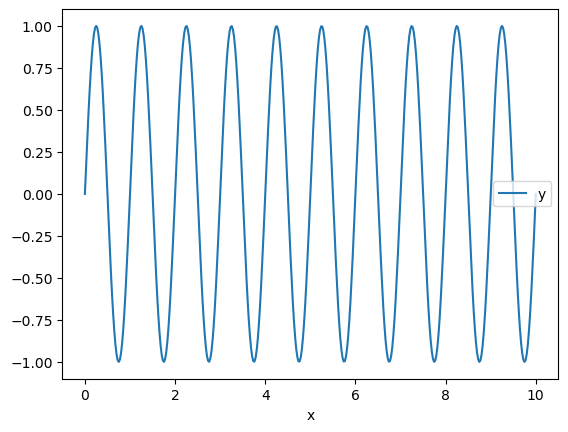

F=1.0, T=1.0, Amplitude=0.9916689864421225


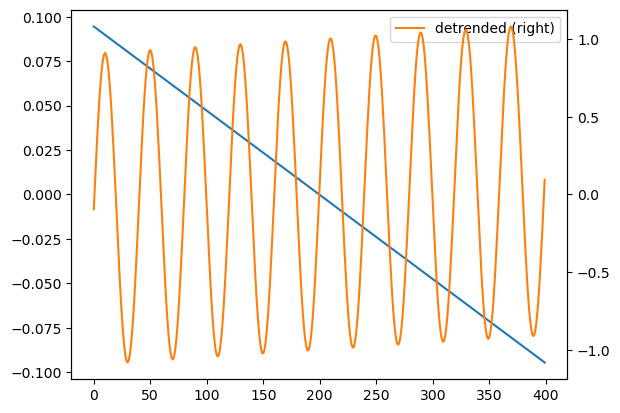

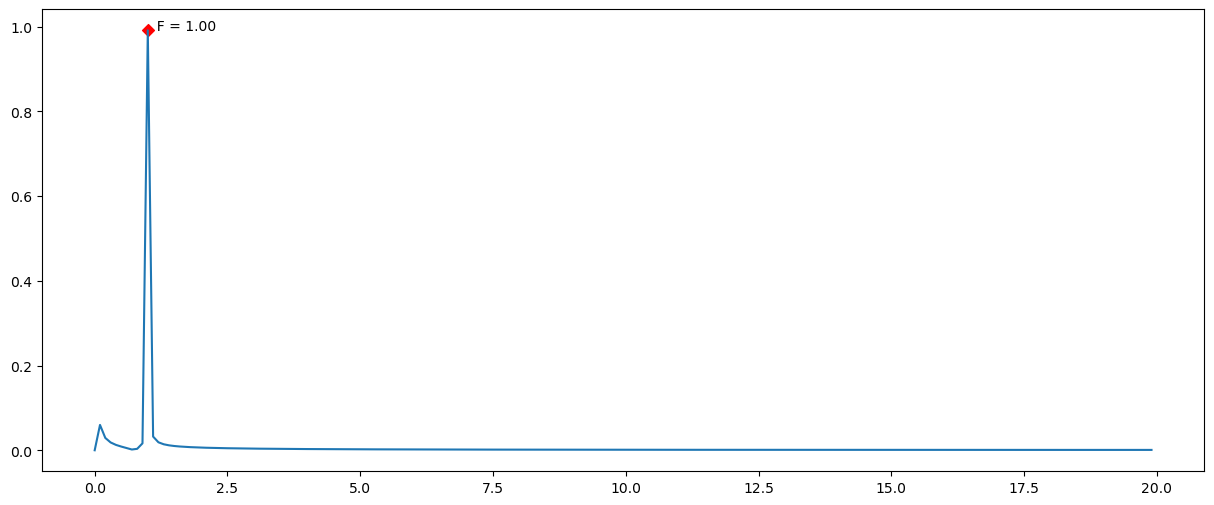

F=0.9375, T=1.0666666666666667, psd=1.7020406794372331


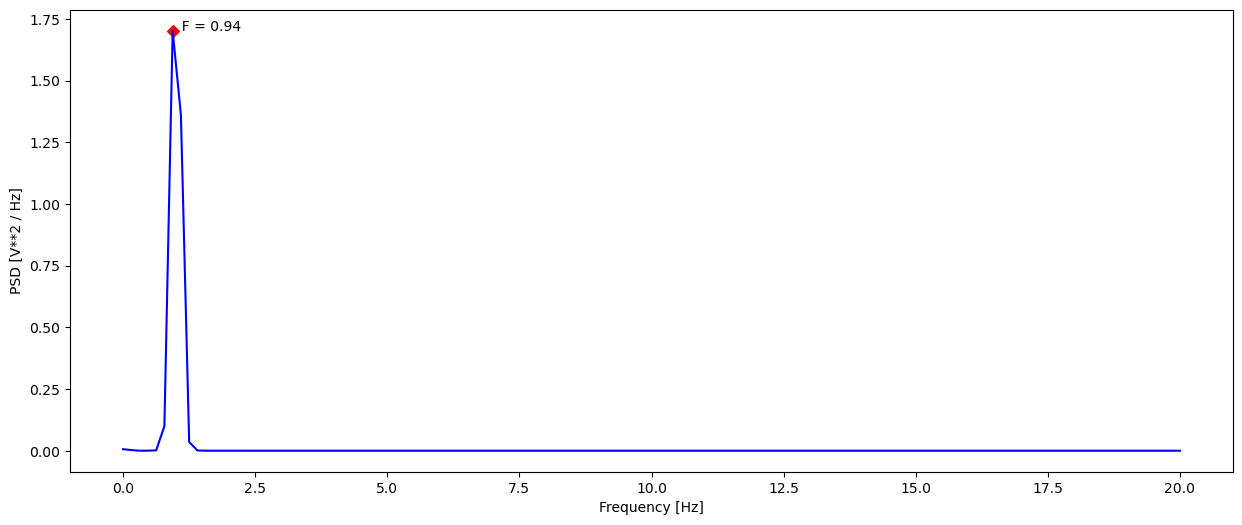

In [5]:
from paper.topic.spectrum import demo

demo(1, 0.5, 0.05)

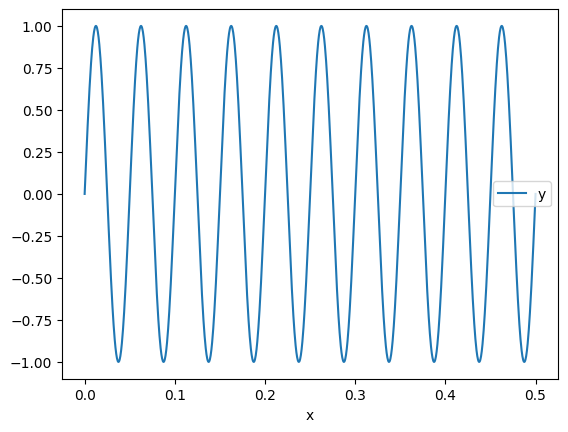

F=2.0, T=0.5, Amplitude=36.30569064083404
F=20.0, T=0.05, Amplitude=596.0400881779651


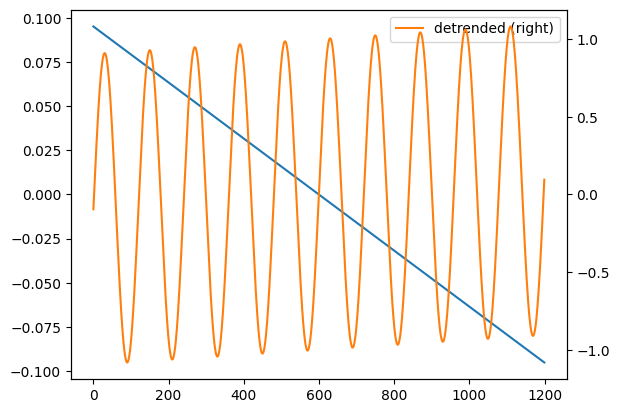

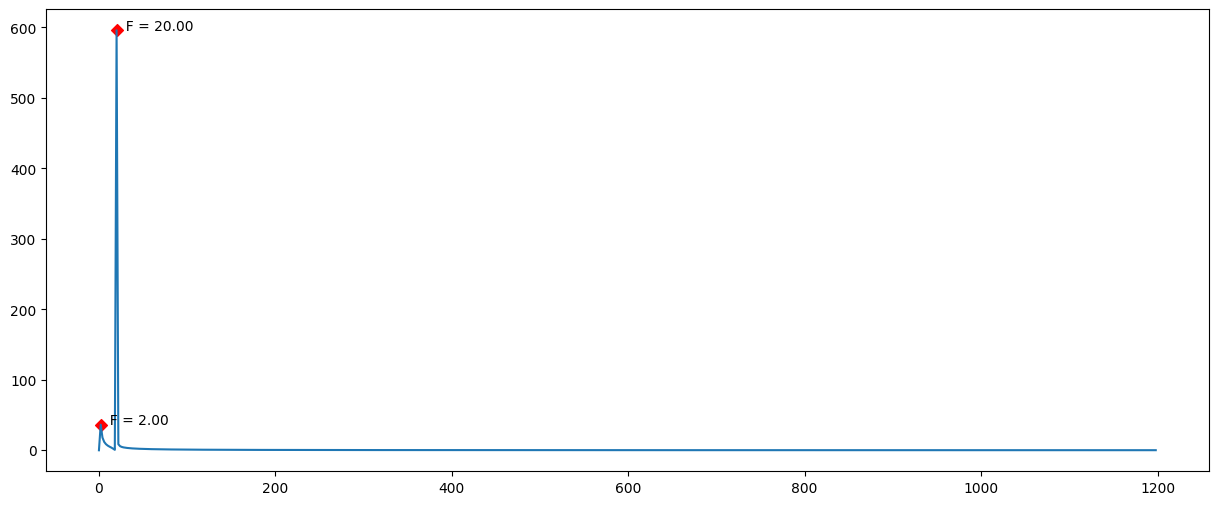

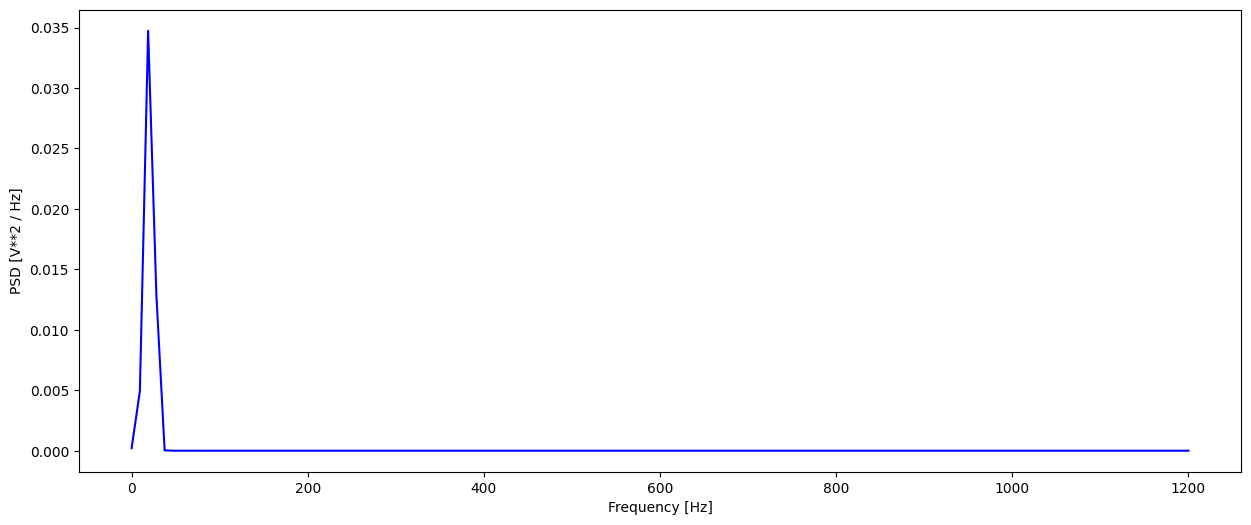

In [11]:
from scipy.signal import savgol_filter
from numpy.fft import fft, fftfreq
from siml.detect_peaks import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def psd(y_values, sampling_frequency, mph=1):
    '''
    sampling_frequency
        the number of samples per second (or per other unit)
    '''

    f_values, psd_values = welch(y_values, fs=sampling_frequency)
    indices_peaks = detect_peaks(psd_values, mph)

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(f_values, psd_values, linestyle='-', color='blue')
    ax.scatter([f_values[i] for i in indices_peaks], [psd_values[i] for i in indices_peaks], color='red',marker='D')
    for idx in indices_peaks:
        x,y = f_values[idx], psd_values[idx]
        text = "  F = {:.2f}".format(x)
        ax.annotate(text, (x,y))
        print('F={}, T={}, psd={}'.format(x, 1/x, y))
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2 / Hz]')
    plt.show()
 
def signal_fft(sampled_signal, sampling_frequency, mph=100):
    assert len(sampled_signal > 50)
    trend =  pd.Series(savgol_filter(sampled_signal, len(sampled_signal),1), index=sampled_signal.index)
    trend.plot()
    detrended = (sampled_signal - trend).rename('detrended')
    detrended.plot(secondary_y=True, legend=True)

    fft_y_  = fft(detrended)
    fft_y = np.abs(fft_y_[:len(fft_y_)//2])
    indices_peaks = detect_peaks(fft_y, mph)

    fft_x_ = fftfreq(len(detrended), 1/sampling_frequency)
    fft_x = fft_x_[:len(fft_x_)//2]
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(fft_x, fft_y)
    ax.scatter([fft_x[i] for i in indices_peaks], [fft_y[i] for i in indices_peaks], color='red',marker='D')
    for idx in indices_peaks:
        x,y = fft_x[idx], fft_y[idx]
        text = "  F = {:.2f}".format(x)
        ax.annotate(text, (x,y))
        print('F={}, T={}, Amplitude={}'.format(x, 1/x, y))

def demo(T=0.05, mph_fft=0.5, mph_psd=0.5):
    amplitude = 1
    frequency = 1 / T
    T_sample_N = 120
    sampling_frequency = T_sample_N / T
    N_periods = 10
    x_value = np.linspace(0, T * N_periods, T_sample_N * N_periods)
    y_values = amplitude*np.sin(2*np.pi*frequency*x_value)
    df = pd.DataFrame({
        'x': x_value,
        'y': y_values
    })
    df.plot(x='x', y='y')
    plt.show()
    signal_fft(df.y, sampling_frequency, mph_fft)
    plt.show()
    psd(df.y, sampling_frequency, mph_psd)

demo(0.05)

2.857142857142857

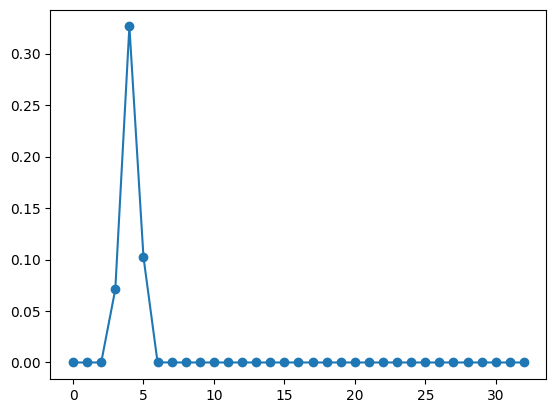

In [36]:
from matplotlib.mlab import psd

amplitude = 1
T = 0.25
frequency = 1 // T
T_sample_N = int(64 * T)
sampling_frequency = T_sample_N // T
N_periods = 4
x_value = np.linspace(0, T * N_periods, T_sample_N * N_periods)
y_values = amplitude*np.sin(2*np.pi*frequency*x_value)
power, fre = psd(y_values, len(y_values), sampling_frequency)
fig,ax = plt.subplots()
ax.plot(fre, power, marker='o')
1 / 0.35



In [4]:
from  sklearn.linear_model import LinearRegression

df = pd.concat([mdi, rolling_return], axis=1).dropna()
df.plot.scatter(x='mdi', y='rolling_return')

model = LinearRegression()
estimator = model.fit(pd.DataFrame(df['mdi']), pd.DataFrame(df['rolling_return']))
estimator.score(pd.DataFrame(df['mdi']), pd.DataFrame(df['rolling_return']))

NameError: name 'rolling_return' is not defined

<BarContainer object of 10 artists>

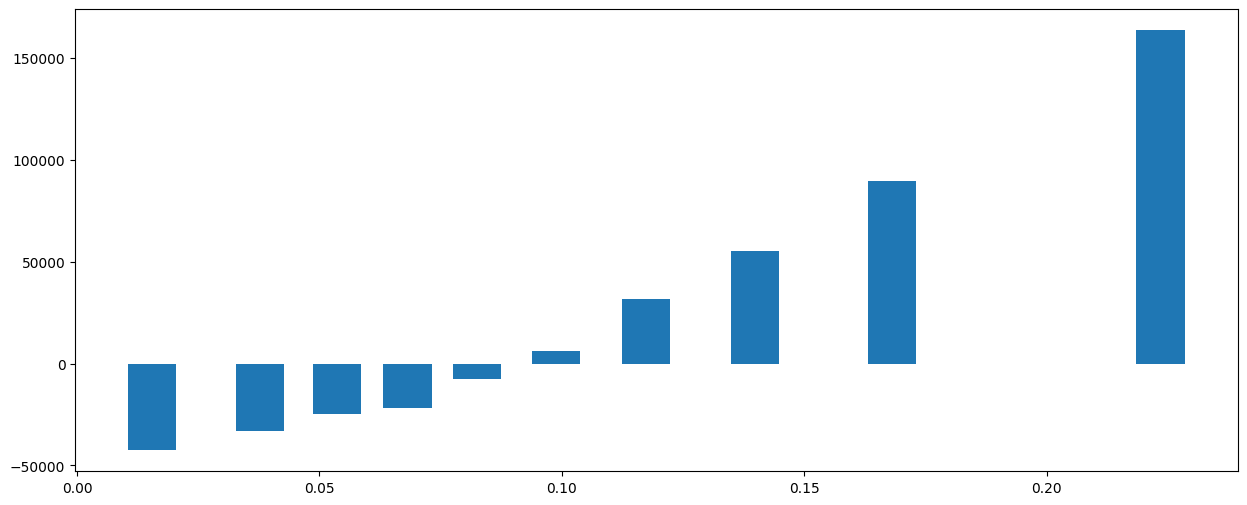

In [ ]:
import numpy as np

xs = []
ys = []
for bin in np.array_split(df.sort_values('mdi'), 10):
    xs.append(bin['mdi'].mean())
    ys.append(bin['rolling_return'].mean())
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(xs, ys, width=0.01)